In [1]:
from __future__ import print_function, division

from ipywidgets import interact
import ipywidgets

import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
%matplotlib inline

PATH = '.'

# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) DBSCAN 
Week 7 | Lesson 4.2

### LEARNING OBJECTIVES
*After this lesson, you will be able to:*
- Explain how DBSCAN works
- Use DBSCAN in Python
- Compare DBSCAN to other forms of clustering
- Bonus: Work with Ipython widgets

## Clustering Algorithm Review: What have we discussed?

## K-Means


<img src="https://upload.wikimedia.org/wikipedia/commons/d/d5/Kmeans_animation.gif">

## K-means

### Pros:

- Easy to implement even on relatively large data sets ( ~$O(n)$ )
- Usually "good enough" results

### Cons:

- Requires an arbitrary k
- Sensitive to outliers (k-medians is more robust)
- With random initial centroids lacks repeatability (but can be seeded)
- Works best if data conforms to circular -> spherical -> hyperspherical shape (n.b. using means)
- Works best with similar density clusters

## Hierarchical Agglomerative Clustering

<img src="http://i.makeagif.com/media/2-24-2014/DkJOLy.gif">

## Hierarchical Clustering

### Pros:

- No need to pick explicit k (...but kinda bc of split point)
- Repeatability/Deterministic model (always get the same clusters) 
- Can dial cluster levels at will
    
### Cons:
    
- Runs in $~O(n^2)$ time - so must be relatively small dataset
- Requires selecting a linkage method

## How might these models go wrong?

<img src="http://i.imgur.com/TglIg05.png" width=500>

<img src="http://i.imgur.com/4g9Kk1i.png" width=600>

## Even on somewhat ideal clusters things can go wrong...

<img src="http://i.imgur.com/p87f1Ac.png" width=600>

## Today We Introduce DBSCAN

DB-WHA? 🤔

## Density-Based Spatial Clustering for Applications with Noise

## The first key 🔑 word here is _density_

## Why Density?

Because DBSCAN works by neighbor-based polling approach. It is ideal for clusters of that have similar variance.

## The second key 🔑 word is _noise_

Noise because not every point will be associated with a cluster. Some are left as outlier points.

## Let's talk about how it works...

Like K-means and HAC, there are some parameters to set

## The Parameters

**Min Points** - This is the minimum number of points required to form a cluster.

**Epsilon** - This is the maximum spanning distance that a point can be from the polling point in order to be recruited to the cluster.

## The order of operations for DBSCAN

**Start at a single, arbitrary chosen data point.** This point's neighborhood (ε) is scanned : if the neighboorhood contains a sufficient number of points (min pts), a cluster is created. All members in the neighborhood are cluster members. Otherwise, if there are not sufficent points to begin a cluster, the point is labeled as noise. 

If the point is labelled as noise, select another random unvisted point, and begin again.

If a cluster is formed (greater than min pts in $\epsilon$), continue outward from each of the cluster points in the same manner with the new cluster members until no other points can be reached. At that time, the cluster is closed and a new random point outside the cluster is selected and the process begins anew.

## Demo

[DBSCAN Demo](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

## Implementing DBSCAN in Python

<img src="http://i.imgur.com/QJmKv08.png">

## Load our data

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.3,
                            random_state=0)

## Plot our data

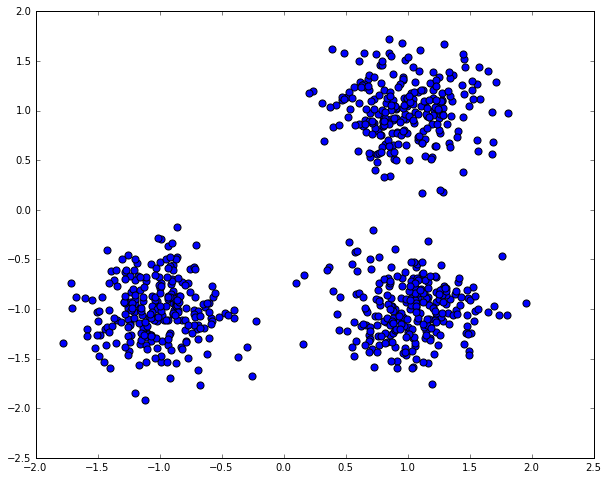

In [3]:
fig = plt.figure(figsize=(10,8))
plt.scatter(X[:,0], X[:,1], s=50)

## Instantiate DBSCAN class with min pts and eps

In [4]:
db = DBSCAN(eps=0.3, min_samples=10)

## Fit the model

In [5]:
X = StandardScaler().fit_transform(X)

db.fit(X)

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    min_samples=10, n_jobs=1, p=None)

## How do you know what good estimates of epsilon and min pts are?

As a general rule when choosing the minimum points - you should always aim to have the **minimum number of points be greater or equal to the amount of dimensions in your data, plus one**. This typically will give the algorithm a good estimation of how to evaluate the clusters. 

Calculating epsilon is a bit trickier and uses a method called the k-distance, which can help visualize the best epsilon. Today, we're going to estimate epsilon so that you can get an understanding of how varying values affect the results of the analysis.

The DBSCAN algorithm in Python returns two items - the core samples and the labels for each point. 

The core samples are the points which the algorithm found that had min pts (continued from there)
Those that are in the cluster but are not core points are border points.

In [6]:
core_samples = db.core_sample_indices_
labels = db.labels_

## Get our Silhouette Score

In [7]:
from sklearn.metrics import silhouette_score

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))

Silhouette Coefficient: 0.660


## Plot our clusters

//anaconda/lib/python2.7/site-packages/matplotlib/lines.py:1106: UnicodeWarning: Unicode unequal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if self._markerfacecolor != fc:


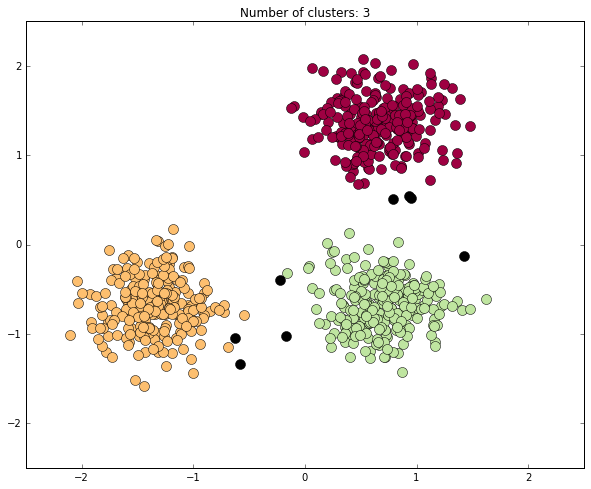

In [8]:
def plot_dbscan(db, X):
    fig = plt.figure(figsize=(10,8))
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=10)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=10)
        
        
    plt.gca().set_xlim(-2.5,2.5)
    plt.gca().set_ylim(-2.5,2.5)
    plt.title('Number of clusters: %d' % n_clusters_);
    
plot_dbscan(db, X)

## Classifier Comparison

<img src="http://i.imgur.com/TkkFBb9.png" width=700>

## Independent Practice

Using the starter code below, change the function so that:
    1. It has sliders for min_pts and eps
    2. It fits a dbscan model
    3. It uses the plot_db() function to return the colored points
    4. It prints out the silhouette score

Bonus:
    1. Add a dropdown widget so that it can fit k-means or HAC clustering

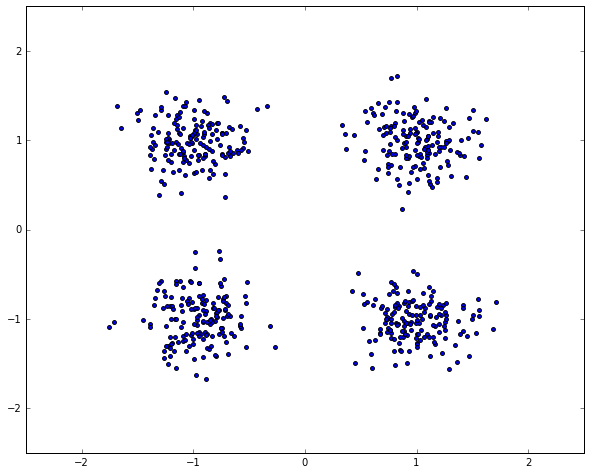

In [9]:
def tweaker(samples, std_dev):
    centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
    X, labels_true = make_blobs(n_samples=samples, centers=centers,
                                cluster_std=std_dev, random_state=44)
    
    # remove lines below and add model fitting code and plotting below
    plt.figure(figsize=(10,8))
    plt.scatter(X[:,0], X[:,1], s=15)
    plt.gca().set_xlim(-2.5,2.5)
    plt.gca().set_ylim(-2.5,2.5)
    

interact(tweaker, samples=(25, 750, 25), std_dev=(.05, .5, .05));

In [ ]:
1. It has sliders for min_pts and eps
2. It fits a dbscan model
3. It uses the plot_db() function to return the colored points
4. It prints out the silhouette score

In [ ]:
def tweaker(samples, std_dev):
    centers = [[1, 1], [-1, -1], [1, -1], [-1, 1]]
    X, labels_true = make_blobs(n_samples=samples, centers=centers,
                                cluster_std=std_dev, random_state=44)
    
    # remove lines below and add model fitting code and plotting below
    plt.figure(figsize=(10,8))
    plt.scatter(X[:,0], X[:,1], s=15)
    plt.gca().set_xlim(-2.5,2.5)
    plt.gca().set_ylim(-2.5,2.5)
    

interact(tweaker, samples=(25, 750, 25), std_dev=(.05, .5, .05));

In [ ]:
db = DBSCAN(eps=0.3, min_samples=10)
X = StandardScaler().fit_transform(X)
db.fit(X)
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(X, labels))
core_samples = db.core_sample_indices_
labels = db.labels_

## Conclusion:

- DBSCAN works well for clustering in the way people tend to imagine clusters
- It takes two parameters: epsilon and min points
- Computationally it runs somewhere between k-means and HAC

## Additional Resources
- [Visualizing DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)
- [IPython Widgets](https://github.com/ipython/ipywidgets)